In [0]:
import numpy as np
from tensorflow.contrib import learn

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D

Using TensorFlow backend.


# download glove twitter data


In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1EYPs1jjOYqe46gBDAreFCtXjGhKqxZKI', dest_path='./glove.zip', unzip=True)

Unzipping...Done.


In [0]:
!pip install import-ipynb
import import_ipynb
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Copy the link and remove the front part of the link (i.e. https://drive.google.com/open?id=) to get the file ID.
your_module = drive.CreateFile({'id':'1Sh3IHhb3HW-0nNPBkKln4GmRGPuEqR6s'})
your_module.GetContentFile('processingdata.ipynb')
import processingdata

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2975 sha256=c293a8092e46299364765683ab646fc627596287d988f6c572892c27eaca6cf8
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
importing Jupyter notebook from processingdata.ipynb
Unzipping...Done.
Unzipping...Done.
The following additional packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
Suggested packages:
  aspell-doc spellutils wordlist hunspell openoffice.org-hunspell
  | openoffice.org-core libenchant-voikko
The following NEW packages will be installed:
  aspell aspell-en dictionaries-common emacsen-common enchant hunspell-en-us
  libaspell15 libenchant1c2a libhunspell-1.6-0 libtext-iconv-perl
0 upgraded, 10 newly installed, 0 to remove and 8 not upgraded.
Need to get 1,300 kB of archives.
After t

# processing data to 'good' text

In [0]:

goodfile='good_Sentiment Analysis Dataset.csv'
badfile='bad_Sentiment Analysis Dataset.csv'
x_text, y = processingdata.get_dataset(goodfile, badfile, 1000000)


In [0]:
print(len(x_text))

1578627



# pre_trained data in glove twitter


In [0]:

your_module = drive.CreateFile({'id':'1OGJqKLf2kIbfWlQd-xzAxgVBk6PDD5Q2'})
your_module.GetContentFile('embedding_layer.ipynb')
import embedding_layer


importing Jupyter notebook from embedding_layer.ipynb


In [0]:

max_document_length = max([len(x.split(" ")) for x in x_text])
print(max_document_length)


229


In [0]:
word_to_index, index_to_word, word_to_vec_map = embedding_layer.read_glove_vecs('glove.twitter.27B.100d.txt')

In [0]:
X_indices1=embedding_layer.sentense_to_indices(x_text,max_document_length,word_to_index)

In [0]:
print(X_indices1.shape)

(1578627, 229)


In [0]:
max_document_length=X_indices1.shape[1]
print(max_document_length)

229


# spilt dataset


In [0]:
from sklearn.model_selection import train_test_split
train_x, test_validation_x, train_y, test_validation_y  = train_test_split(X_indices1, y, test_size=0.2, random_state=2019)
val_x, test_x, val_y, test_y = train_test_split(test_validation_x, test_validation_y, test_size=0.5, random_state=2018)

# Build model


In [0]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling1D,Bidirectional,GlobalMaxPooling1D
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import LSTM,CuDNNLSTM
import keras
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D

In [0]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
  vocab_len=len(word_to_index)+1 # adding 1 to fit Keras embedding (requirement)
  embed_dim=100
   # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
  emb_matrix = np.zeros((vocab_len, embed_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
  for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
  embedding_layer = Embedding(vocab_len, embed_dim, trainable=False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
  embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
  embedding_layer.set_weights([emb_matrix])
    
  return embedding_layer

In [0]:
def sentiment_analysis(input_shape, word_to_vec_map, word_to_index):
  sentence_indices = Input(input_shape, dtype='int32')
   # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
  embed = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
  embeddings = embed(sentence_indices) 

  x=CuDNNLSTM(units=128, return_sequences=True)(embeddings)
  x=Dropout(0.25)(x)
  x=CuDNNLSTM(units=128, return_sequences=True)(x)

  
  x=Conv1D(64,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1)(x)
# we use max pooling:
  x=GlobalMaxPooling1D()(x)

  x=Dense(32)(x)
  x=Activation('relu')(x)

  x=Dense(1)(x)
  x=Activation('sigmoid')(x)
  model = Model(inputs=sentence_indices, outputs=x)
    

  return model


In [0]:
model= sentiment_analysis((max_document_length,), word_to_vec_map, word_to_index)

model.summary()











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 229)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 229, 100)          119351500 
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 229, 128)          117760    
_________________________________________________________________
dropout_1 (Dropout)          (None, 229, 128)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 229, 128)          132096    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 227, 64)           24640     


In [0]:
mcp = keras.callbacks.ModelCheckpoint("my_model2.h5", monitor="val_acc",verbose=2,mode='max',
                      save_best_only=True)
    
    # Compile model
model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
    
batch_size=128
epochs=20

In [0]:
history=model.fit(train_x, train_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(val_x, val_y),callbacks=[mcp])

Train on 1262901 samples, validate on 157863 samples
Epoch 1/20
1262901/1262901 [==============================] - 1093s 866us/step - loss: 0.3835 - acc: 0.8267 - val_loss: 0.3683 - val_acc: 0.8349

Epoch 00001: val_acc improved from -inf to 0.83494, saving model to my_model2.h5
Epoch 2/20
1262901/1262901 [==============================] - 1101s 872us/step - loss: 0.3599 - acc: 0.8398 - val_loss: 0.3627 - val_acc: 0.8387

Epoch 00002: val_acc improved from 0.83494 to 0.83873, saving model to my_model2.h5
Epoch 3/20
1262901/1262901 [==============================] - 1104s 874us/step - loss: 0.3463 - acc: 0.8469 - val_loss: 0.3546 - val_acc: 0.8430

Epoch 00003: val_acc improved from 0.83873 to 0.84298, saving model to my_model2.h5
Epoch 4/20
1262901/1262901 [==============================] - 1106s 876us/step - loss: 0.3361 - acc: 0.8522 - val_loss: 0.3514 - val_acc: 0.8452

Epoch 00004: val_acc improved from 0.84298 to 0.84519, saving model to my_model2.h5
Epoch 5/20
1262901/1262901 [==

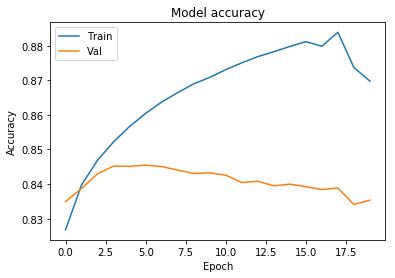

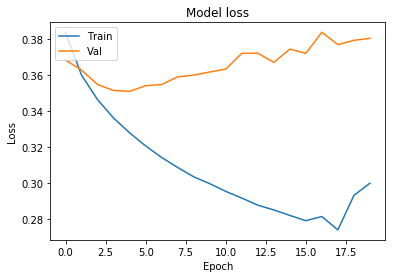

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('books_read1.png')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('books_read2.png')
plt.show()

# evaluate the test dataset


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd '/content/drive/My Drive/aominebka991/sentiment analysis twitter project'

/content/drive/My Drive/aominebka991/sentiment analysis twitter project


In [0]:
from keras.models import load_model
saved_model = load_model('my_model2.h5')

In [0]:
from keras.models import load_model
saved_model = load_model('my_model2.h5')
# evaluate the model

scores = saved_model.evaluate(test_x, test_y, verbose=1,batch_size=256)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

157863/157863 [==============================] - 32s 202us/step
Test loss: 0.3782957815161078
Test accuracy: 0.8372132798526406


In [0]:
def predict_sample(model,lstr,max_document_length,word_to_index,threshold=0.5):
  
  lstr=[processingdata.clean_str(y) for y in lstr]
  lstr_indices=embedding_layer.sentense_to_indices(lstr,max_document_length,word_to_index)
  face=model.predict(lstr_indices)

  sentiment=[]
  for x in face:
    if x >= threshold: sentiment.append(1)
    else: sentiment.append(0)
  return sentiment

In [0]:
predict_sample(saved_model,["Machine learning is so hard to learn but i still like it"],max_document_length,word_to_index,threshold=0.5)

[1]